In [29]:
# import packages
import sys

import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax 
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.25.2
tensorflow version = 2.14.0


In [7]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

# Data preparation

In [9]:
# read in data
ORAp_t = '../data/sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = '../data/sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = '../data/sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = '../data/somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

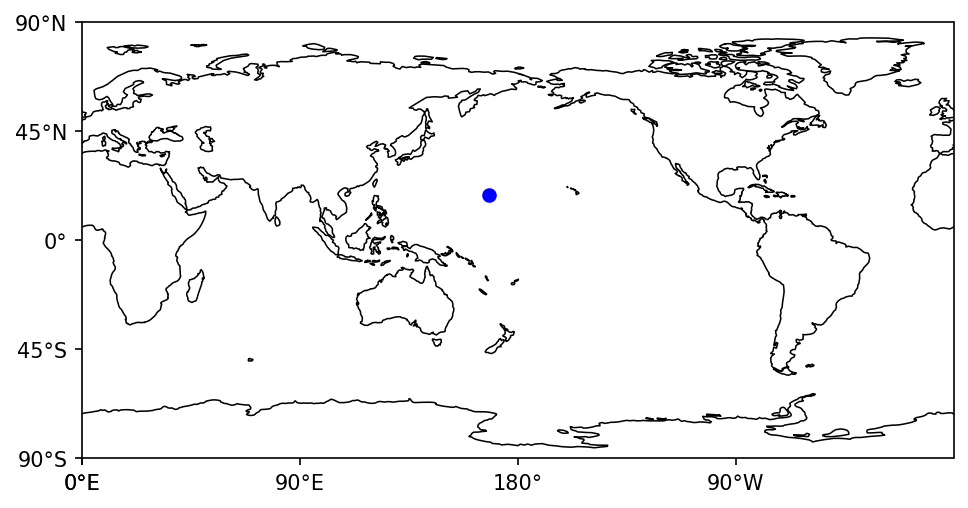

In [12]:
# pick a grid point
ilat = 90
ilon = 140

if ma.is_masked(ORA_SST[:,ilat,ilon]):
    print('Land! Try to pick a ocean grid :D')
else:
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(linewidth=.75)
    ax.set_global()

    ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.plot(lon[ilon], lat[ilat], 'ob', transform=ccrs.PlateCarree())
    
    plt.show()

In [13]:
# calculate climatology
OSST_c = np.nanmean(np.array(ORA_SST[:,ilat,ilon]).reshape((int(len(ORA_SST[:,ilat,ilon])/12), 12)), axis=0)
OSSH_c = np.nanmean(np.array(ORA_SSH[:,ilat,ilon]).reshape((int(len(ORA_SSH[:,ilat,ilon])/12), 12)), axis=0)
OSSS_c = np.nanmean(np.array(ORA_SSS[:,ilat,ilon]).reshape((int(len(ORA_SSS[:,ilat,ilon])/12), 12)), axis=0)
OMLD_c = np.nanmean(np.array(ORA_MLD[:,ilat,ilon]).reshape((int(len(ORA_MLD[:,ilat,ilon])/12), 12)), axis=0)
OSST_cf = np.tile(OSST_c, int(len(ORA_SST[:,ilat,ilon])/12))
OSSH_cf = np.tile(OSSH_c, int(len(ORA_SSH[:,ilat,ilon])/12))
OSSS_cf = np.tile(OSSS_c, int(len(ORA_SSS[:,ilat,ilon])/12))
OMLD_cf = np.tile(OMLD_c, int(len(ORA_MLD[:,ilat,ilon])/12))

# remove climatology (just for predictors)
OSST_a = ORA_SST[:,ilat,ilon] - OSST_cf
OSSH_a = ORA_SSH[:,ilat,ilon] - OSSH_cf
OSSS_a = ORA_SSS[:,ilat,ilon] - OSSS_cf

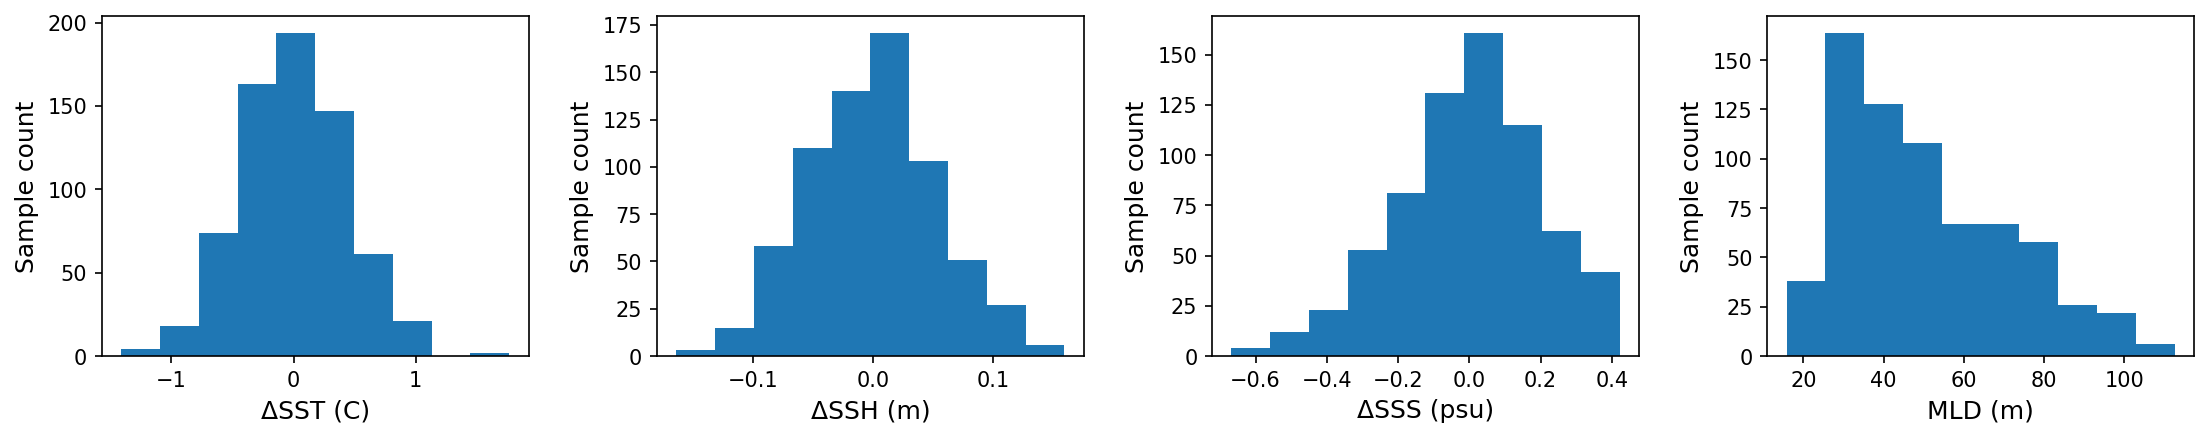

In [14]:
# check timeseries distribution
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_ylabel('Sample count')

axs[0].set_xlabel('\u0394SST (C)')
axs[1].set_xlabel('\u0394SSH (m)')
axs[2].set_xlabel('\u0394SSS (psu)')
axs[3].set_xlabel('MLD (m)')

axs[0].hist(OSST_a)
axs[1].hist(OSSH_a)
axs[2].hist(OSSS_a)
axs[3].hist(ORA_MLD[:,ilat,ilon])
        
fig.subplots_adjust(wspace=0.3)
plt.show()

In [51]:
# predictors and predictand
X = np.empty((len(OSST_a), 7))
X[:,:] = np.nan

X[:,0] = monthofYear
X[:,1] = OSST_cf
X[:,2] = OSSH_cf
X[:,3] = OSSS_cf
X[:,4] = OSST_a
X[:,5] = OSSH_a
X[:,6] = OSSS_a

y = np.copy(ORA_MLD[:,ilat,ilon])

label_names = ['MLD']
feature_list = ['month of year', 'SST - climatology', 'SSH - climatology', 'SSS - climatology', 'SST - anomaly', 'SSH - anomaly', 'SSS - anomaly']

# Train/test set

In [52]:
# spliting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # the same as in the random forest model

# how about spliting dataset by different time periods?

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (513, 7)
Testing Features Shape: (171, 7)


In [56]:
# standardize inputs and output
standardize_input = lambda dat, x, s: (dat - x) / s

# Calculate mean and standard deviation of the training data
trainmean = X_train[:,1:].mean(axis=0)
trainstd = X_train[:,1:].std(axis=0)

# create new arrays for standardized data (coz monthofyear cannot be standardized, nor can it be removed from training/testing set)
Xtrain = np.empty(np.shape(X_train))
Xtest = np.empty(np.shape(X_test))

Xtrain[:,0] = X_train[:,0]
Xtest[:,0] = X_test[:,0]

Xtrain[:,1:] = standardize_input(X_train[:,1:], trainmean, trainstd)
Xtest[:,1:] = standardize_input(X_test[:,1:], trainmean, trainstd)

# A simple, fully-connected neutral network

In [41]:
# define parameters
n_units = 3 # number of units in each layer
bsize = 30 # Train on batches of 30 samples (chunk size)
n_epochs = 50 # Epochs: run through all training data that many times. Order gets shuffled.


In [62]:
# define the model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Input layer:
input_layer = tf.keras.layers.Input(shape=[Xtrain.shape[1:][0]-1]) # train on X except monthofyear

# First hidden layer: densely-connected layer with n_units units and activation function 'relu'.
hidden1 = layers.Dense(n_units, activation='relu')(input_layer)

# Second hidden layer:
hidden2 = layers.Dense(n_units, activation='relu')(hidden1)

# final layer:  just 1 node and no activation function
output_layer = layers.Dense(1, activation=None)(hidden2)
    
# complete and compile the model:
model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer=keras.optimizers.Adam(0.01),  # Adam optimizer
            loss='mae',                               # mean absolute error = mae
            metrics=['mse'])                          # mean squared error = mse

In [65]:
# train the model
history = model.fit(Xtrain[:,1:], y_train, epochs=n_epochs, batch_size=bsize, validation_split=0.2, shuffle=True)

print(model.summary())

Epoch 1/50
14/14 [==============================] - 1s 12ms/step - loss: 51.1427 - mse: 3034.0703 - val_loss: 50.1040 - val_mse: 2945.2854
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 50.7162 - mse: 2991.7664 - val_loss: 49.7512 - val_mse: 2910.2590
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 50.2889 - mse: 2947.9595 - val_loss: 49.2192 - val_mse: 2856.4138
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 49.5159 - mse: 2868.6433 - val_loss: 48.1663 - val_mse: 2752.0759
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 47.9900 - mse: 2718.7014 - val_loss: 46.2163 - val_mse: 2567.9277
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 45.3493 - mse: 2478.2356 - val_loss: 42.8304 - val_mse: 2281.9429
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 40.9624 - mse: 2123.2400 - val_loss: 37.7267 - val_mse: 1912.4089
Epoch 8/50
14/14 [===============

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


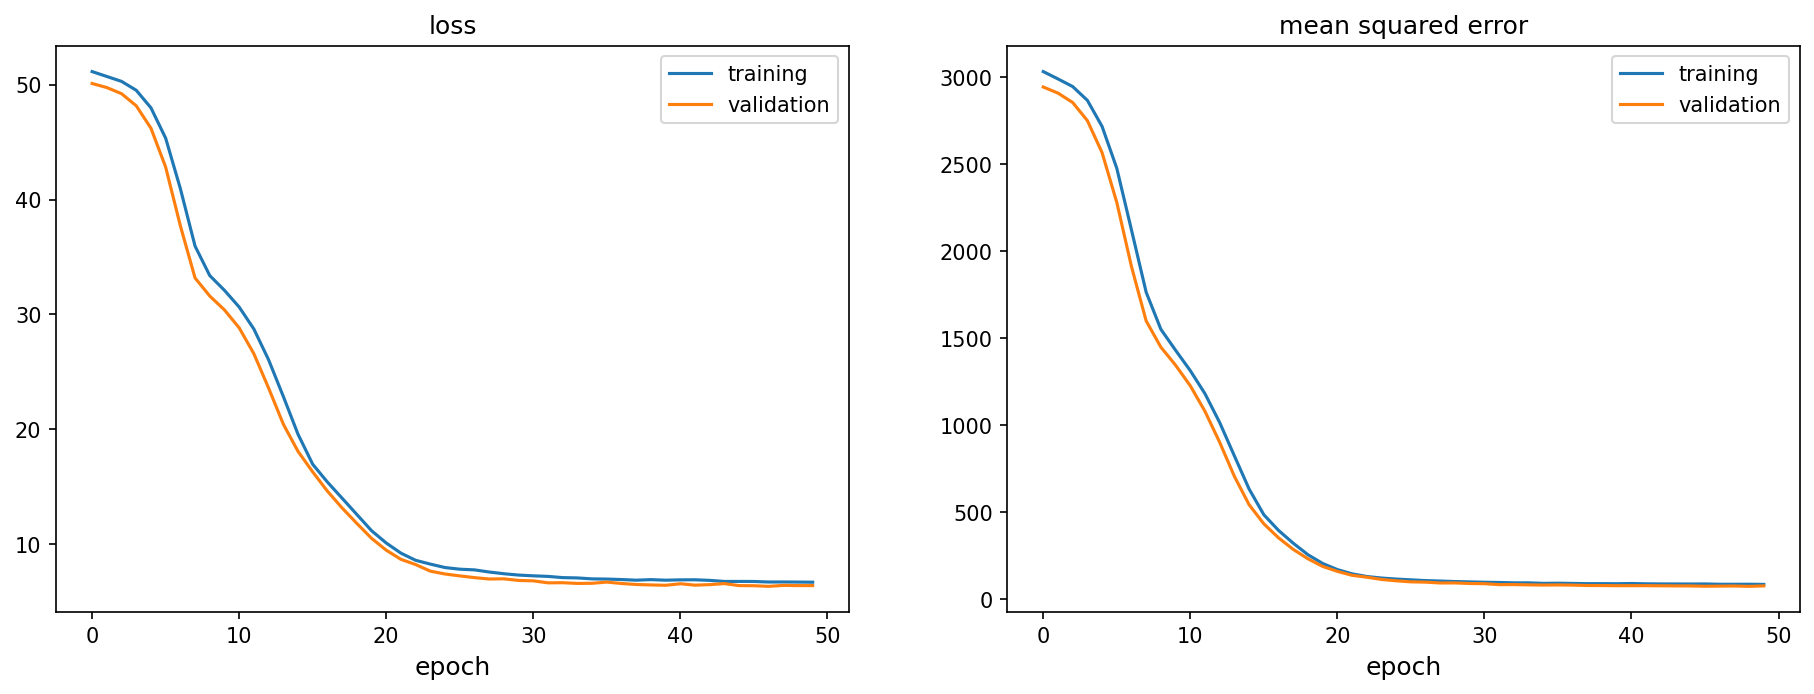

In [66]:
# plot the loss during training
print(history.history.keys())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mse'],label = 'training')
plt.plot(history.history['val_mse'], label = 'validation')
plt.title('mean squared error')
plt.xlabel('epoch')
plt.legend()

plt.show()

# Use the NN model to predict

In [67]:
# make predictions for training and testing set
y_pred_train = model.predict(Xtrain[:,1:])
y_pred_test = model.predict(Xtest[:,1:])

6/6 [==============================] - 0s 1ms/step


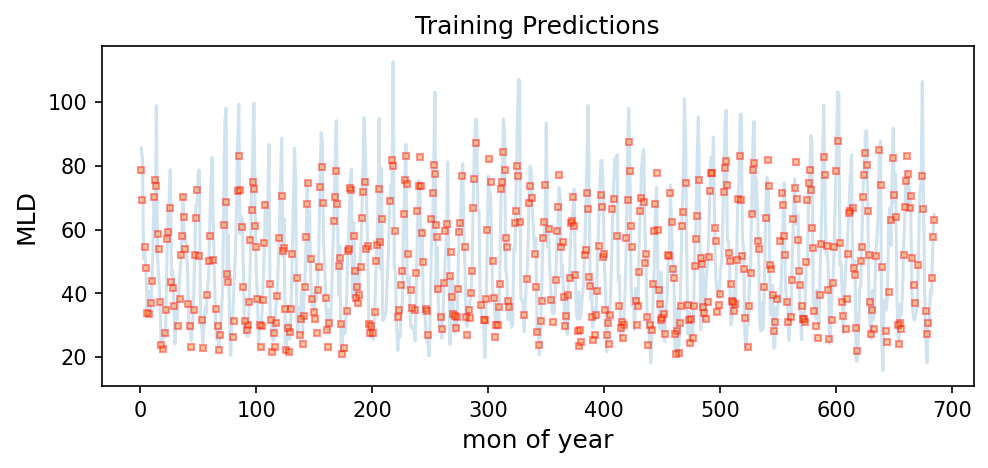

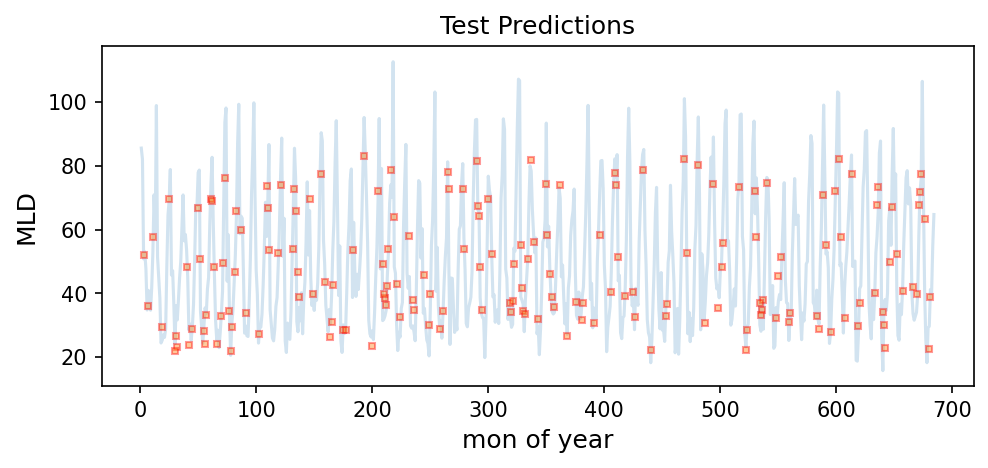

In [68]:
# plot predicted values
for split_type in ("Training", "Test"):
    if split_type == "Training":
        plot_features = Xtrain
        plot_pred = y_pred_train
    elif split_type == "Test":
        plot_features = Xtest
        plot_pred = y_pred_test
    else:
        raise NotImplementedError()

    fig, ax = plt.subplots(figsize=(7.5, 3))

    ax.plot(X[:,0], ORA_MLD[:,ilat,ilon], alpha=0.2)
    ax.plot(plot_features[:,0], plot_pred, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
    ax.set_xlabel("mon of year")
    ax.set_ylabel("MLD")

    plt.title(split_type + " Predictions")
    plt.show()